In [19]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV


Preprocessing

In [20]:
def preprocess_data_with_target(df, target):
    """
    Preprocess dataset with target variable:
      - Handles missing values
      - Encodes categorical features
      - Standardizes numerical features
      - Separates features (X) and target (y)
    
    Parameters
    ----------
    df : pandas.DataFrame
        The dataset to preprocess.
    target : str
        The name of the target column.

    Returns
    -------
    X : pandas.DataFrame
        Processed feature matrix
    y : pandas.Series
        Encoded target column
    encoders : dict
        LabelEncoders used for categorical columns
    scaler : StandardScaler
        Scaler fitted on numeric columns
    """

    print(f"First 5 Rows of Data before transformation: \n{df.head()}\n********************* \n")

    # Handle Missing Values
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:  # numeric
            df[col] = df[col].fillna(df[col].mean())
        else:  # categorical
            df[col] = df[col].fillna(df[col].mode()[0])

    # Separate Features and Target
    X = df.drop(columns=[target])
    y = df[target]

    # Encode Categorical Columns
    encoders = {}
    for col in X.select_dtypes(include=['object', 'category']).columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        encoders[col] = le

    # Encode target if categorical
    if y.dtype == 'object' or str(y.dtype) == 'category':
        le_target = LabelEncoder()
        y = le_target.fit_transform(y)
        encoders[target] = le_target

    # Standardize Numerical Features
    scaler = StandardScaler()
    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
    X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

    print(f"\n********************* \nFirst 5 Rows of X after transformation: \n{X.head()}\n*********************")
    print(f"First 5 Rows of y after transformation: \n{y[:5]}\n********************* \n")

    return X, y, encoders, scaler



In [21]:
def preprocess_data_no_target(df):
    """
    Preprocess dataset without a target variable:
      - Handles missing values
      - Encodes categorical features
      - Standardizes numerical features

    Parameters
    ----------
    df : pandas.DataFrame
        The dataset to preprocess.

    Returns
    -------
    X : pandas.DataFrame
        Processed feature matrix
    encoders : dict
        LabelEncoders used for categorical columns
    scaler : StandardScaler
        Scaler fitted on numeric columns
    """

    print(f"First 5 Rows of Data before transformation: \n{df.head()}\n********************* \n")

    # ---- Handle Missing Values ----
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:  # numeric
            df[col] = df[col].fillna(df[col].mean())
        else:  # categorical
            df[col] = df[col].fillna(df[col].mode()[0])

    # ---- Encode Categorical Columns ----
    encoders = {}
    for col in df.select_dtypes(include=['object', 'category']).columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        encoders[col] = le

    # ---- Standardize Numerical Features ----
    scaler = StandardScaler()
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

    print(f"\n********************* \nFirst 5 Rows of Data after transformation: \n{df.head()}\n*********************")

    return df, encoders, scaler


In [22]:
# Load project_adult.csv as pa
pa = pd.read_csv("project_adult.csv")

# Apply preprocess function on pa
pa_X, pa_y, pa_encoders, pa_scaler = preprocess_data_with_target(df = pa, target = "income")

First 5 Rows of Data before transformation: 
   Unnamed: 0  age         workclass  fnlwgt     education  education-num  \
0        5514   33         Local-gov  198183     Bachelors             13   
1       19777   36           Private   86459     Assoc-voc             11   
2       10781   58  Self-emp-not-inc  203039           9th              5   
3       32240   21           Private  180190     Assoc-voc             11   
4        9876   27           Private  279872  Some-college             10   

       marital-status       occupation   relationship   race     sex  \
0       Never-married   Prof-specialty  Not-in-family  White  Female   
1  Married-civ-spouse  Exec-managerial        Husband  White    Male   
2           Separated     Craft-repair  Not-in-family  White    Male   
3  Married-civ-spouse  Farming-fishing        Husband  White    Male   
4            Divorced    Other-service  Not-in-family  White    Male   

   capital-gain  capital-loss  hours-per-week native-countr

In [23]:
# Load project_validation_inputs.csv as pv
pv = pd.read_csv("project_validation_inputs.csv")

# Apply preprocess function on pa
pv_X, pv_encoders, pv_scaler = preprocess_data_no_target(df = pv)

First 5 Rows of Data before transformation: 
   Unnamed: 0  age         workclass  fnlwgt     education  education-num  \
0       14160   27           Private  160178  Some-college             10   
1       27048   45         State-gov   50567       HS-grad              9   
2       28868   29           Private  185908     Bachelors             13   
3        5667   30           Private  190040     Bachelors             13   
4        7827   29  Self-emp-not-inc  189346  Some-college             10   

       marital-status         occupation   relationship   race     sex  \
0            Divorced       Adm-clerical  Not-in-family  White  Female   
1  Married-civ-spouse    Exec-managerial           Wife  White  Female   
2  Married-civ-spouse    Exec-managerial        Husband  Black    Male   
3       Never-married  Machine-op-inspct  Not-in-family  White  Female   
4            Divorced       Craft-repair  Not-in-family  White    Male   

   capital-gain  capital-loss  hours-per-week n

Support Vector Machines

In [24]:
X_train, X_test, y_train, y_test = train_test_split(pa_X, pa_y, test_size=0.25, random_state=42, stratify=pa_y)


In [25]:
def plot_confusion_matrix(cm, y_true):
    """
    Plots the confusion matrix using a heatmap.

    Args:
        cm (np.ndarray): The confusion matrix.
        y_true (np.ndarray): The true labels for the test data.
    """
    # Create the plot using pure matplotlib
    fig, ax = plt.subplots(figsize=(8, 6))
    # Use imshow to create the heatmap
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=np.unique(y_true), yticklabels=np.unique(y_true),
           ylabel='True label', xlabel='Predicted label')
    plt.title("Confusion Matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [26]:
# We use GridSearchCV to find the best hyperparameters for the model.
# Cross-validation (CV) helps to get a more robust estimate of model performance
# and prevents overfitting to a single train-test split.

# Define the parameter grid to search over.
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}


# Initialize GridSearchCV with a 5-fold cross-validation strategy.
grid_search = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid,
    cv=5,                     # 5-fold cross-validation
    scoring='accuracy',       # Metric to optimize for
    n_jobs=-1,                # Use all available CPU cores
    verbose=1                 # Print progress
)

print("Starting hyperparameter search. This may take a moment...")
# If y_train is a numpy array use ravel(), if pandas Series just use y_train
grid_search.fit(X_train, y_train.ravel())

Starting hyperparameter search. This may take a moment...
Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='accuracy', verbose=1)


--- Best Model Found by GridSearchCV ---
Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation accuracy: 0.8477

 Final evaluation of the best model on the test set...
Final accuracy on test set: 0.8417

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      4945
           1       0.74      0.53      0.62      1567

    accuracy                           0.84      6512
   macro avg       0.80      0.74      0.76      6512
weighted avg       0.83      0.84      0.83      6512


Confusion Matrix:
[[4651  294]
 [ 737  830]]


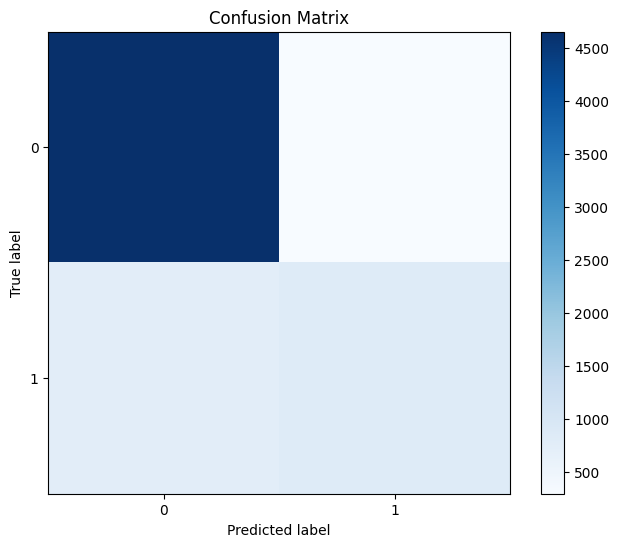

In [27]:
# Get the best estimator from the search.
best_model = grid_search.best_estimator_

print("\n--- Best Model Found by GridSearchCV ---")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

print("\n Final evaluation of the best model on the test set...")
# Predict using the best model found during the search.
final_y_pred = best_model.predict(X_test)
final_accuracy = accuracy_score(y_test, final_y_pred)

print(f"Final accuracy on test set: {final_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, final_y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, final_y_pred)
print(cm)

# Plot the predictions and the confusion matrix
plot_confusion_matrix(cm, y_test)

In [32]:
validation_preds = best_model.predict(pv_X.values)

# Map predictions back to original income labels if pa_encoders available
target_le = pa_encoders.get("income")
if target_le is not None:
    readable_preds = target_le.inverse_transform(validation_preds)
    output_df = pv.copy()
    output_df['Predicted_Income'] = readable_preds
else:
    output_df = pv.copy()
    output_df['Predicted_Income'] = validation_preds

# save just output labels using SVM model output filename
output_df[['Predicted_Income']].to_csv("Group_23_SVM_PredictedOutputs.csv", index=False)
print("Validation predictions saved to Group_23_SVM_PredictedOutputs.csv")
# ...existing code...

/Users/jmlaurie/miniconda3/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Validation predictions saved to Group_23_SVM_PredictedOutputs.csv


Top 2 features: ['education-num', 'capital-gain']
Their importance scores: [0.04210687960687962, 0.039588452088452145]


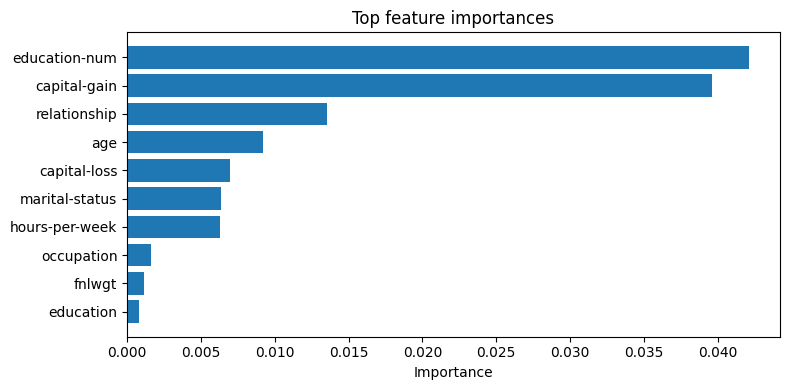

In [28]:
from sklearn.inspection import permutation_importance
import numpy as np

import matplotlib.pyplot as plt

# Use feature names from the training/features dataframe
feature_names = X_train.columns

# If model exposes linear coefficients use them, otherwise use permutation importance
if hasattr(best_model, "coef_"):
    # For multi-class or multi-coef shapes, collapse to absolute mean importance per feature
    coefs = np.abs(best_model.coef_)
    if coefs.ndim > 1:
        importances = coefs.mean(axis=0)
    else:
        importances = coefs.ravel()
else:
    # Permutation importance on the held-out test set
    res = permutation_importance(
        best_model, X_test, y_test,
        n_repeats=5,         
        random_state=42,
        n_jobs=-1,
        scoring="accuracy"
    )
    importances = res.importances_mean

# Rank features and pick top-2
sorted_idx = np.argsort(importances)[::-1]
top2_idx = sorted_idx[:2]
top2_features = feature_names[top2_idx].tolist()
top2_scores = importances[top2_idx].tolist()

print("Top 2 features:", top2_features)
print("Their importance scores:", top2_scores)

# Plot the feature importances
top_n = min(10, len(feature_names))
plt.figure(figsize=(8, 4))
plt.barh(feature_names[sorted_idx[:top_n]][::-1], importances[sorted_idx[:top_n]][::-1])
plt.xlabel("Importance")
plt.title("Top feature importances")
plt.tight_layout()
plt.show()

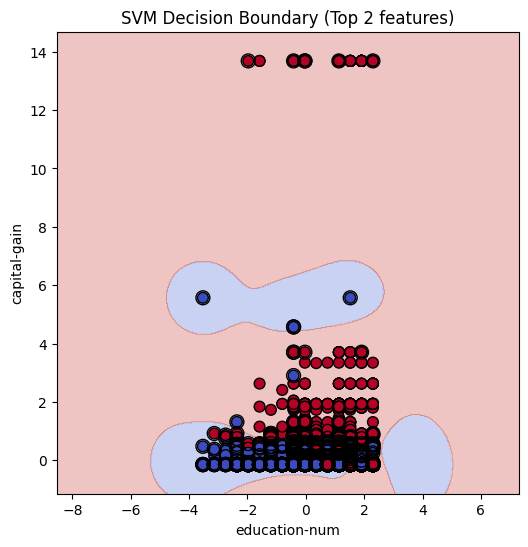

In [29]:
def plot_best_svm_decision_boundary(grid_search, X, y, top2_features):
    """
    Plots the decision boundary for the best SVM model found by GridSearchCV
    using only the features listed in top2_features.

    Args:
        grid_search (GridSearchCV): The fitted GridSearchCV object.
        X (pd.DataFrame): The input features (must be a DataFrame for feature names).
        y (pd.Series or np.ndarray): The target labels.
        top2_features (list): List of two feature names to plot.
    """
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_kernel = best_params.get('kernel', 'linear') # Default to linear if not found

    # Standardize y input and encode if necessary
    if isinstance(y, pd.DataFrame):
        if y.shape[1] != 1:
            raise ValueError("If 'y' is a DataFrame, it must contain a single column.")
        y_series = y.iloc[:, 0]
    elif isinstance(y, (pd.Series, np.ndarray)):
        y_series = pd.Series(y).ravel()
    else:
        raise TypeError("y must be a pandas DataFrame, Series, or a NumPy array.")
    
    if y_series.dtype == 'object':
        print("Encoding string labels to numerical format...")
        le = LabelEncoder()
        y_encoded = le.fit_transform(y_series)
    else:
        y_encoded = np.array(y_series)

    # Check input feature validity
    if len(top2_features) != 2:
        raise ValueError("top2_features must be a list of exactly two feature names.")
    for feature in top2_features:
        if feature not in X.columns:
            raise ValueError(f"Feature '{feature}' not found in input DataFrame.")

   # Select the two specified features
    X_pair = X.loc[:, top2_features]
    f1_name, f2_name = top2_features

    # Retrain model on these two features for plotting
    plot_model = SVC(
        kernel=best_params.get('kernel'),
        C=best_params.get('C'),
        gamma=best_params.get('gamma')
    )
    if best_kernel == 'poly':
        plot_model.degree = best_params.get('degree', 3)
    plot_model.fit(X_pair.values, y_encoded)

        # Meshgrid limits with ±1 padding
    x_min, x_max = X_pair.iloc[:, 0].min() - 1, X_pair.iloc[:, 0].max() + 1
    y_min, y_max = X_pair.iloc[:, 1].min() - 1, X_pair.iloc[:, 1].max() + 1

    # Make the plot square by using the same range for both axes
    x_range = x_max - x_min
    y_range = y_max - y_min
    max_range = max(x_range, y_range)
    x_mid = (x_max + x_min) / 2
    y_mid = (y_max + y_min) / 2
    x_min_sq = x_mid - max_range / 2
    x_max_sq = x_mid + max_range / 2
    y_min_sq = y_mid - max_range / 2
    y_max_sq = y_mid + max_range / 2

    xx, yy = np.meshgrid(np.linspace(x_min_sq, x_max_sq, 500),
                         np.linspace(y_min_sq, y_max_sq, 500))

    # Predict grid points
    Z = plot_model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot decision boundary and data
    plt.figure(figsize=(6, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X_pair.iloc[:, 0], X_pair.iloc[:, 1], c=y_encoded,
                edgecolors='k', cmap=plt.cm.coolwarm, s=60)
    plt.scatter(plot_model.support_vectors_[:, 0], plot_model.support_vectors_[:, 1],
                s=100, linewidth=1, facecolors='none', edgecolors='k')

    plt.xlabel(f1_name)
    plt.ylabel(f2_name)
    plt.title(f"SVM Decision Boundary (Top 2 features)")
    plt.xlim(x_min_sq, x_max_sq)
    plt.ylim(y_min_sq, y_max_sq)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

plot_best_svm_decision_boundary(grid_search, X_train, y_train, top2_features)